Il progetto estrae delle relazioni fra qualsiasi nome dato in input e i nomi suggeriti da Google quando si cerca un'alternativa a qualcosa, ovvero i suggerimenti che comparirebbero nella barra di ricerca scrivendo "[nome] vs ...". Lo scopo del progetto è ottenere una classifica dei filosofi più influenti della storia, ma il programma può essere applicato a qualsiasi cosa, basta che si vogliano mettere a confronto delle alternative dello stesso settore (marche, programmi, linguaggi di programmazione, ideologie ecc.)

In [1]:
#!pip install pyvis

In [2]:
import xml.etree.ElementTree as ET
import networkx as nx
import networkx.algorithms as nxa
import matplotlib.pyplot as plt
import urllib3
import pandas as pd
import urllib.request
import pyvis
from pyvis.network import Network

In [3]:
# Stopword con parole che sono risultate fuorvianti per la ricerca dei filosofi.
stopword=['mcintosh','bacon','vanden','mcquaidfootball2021','mcquaid basketball','mcquaid football 2021','glonass','gps','mashy spike plate','aamc','master chief','drill press','router','campus','campbellsport football', 'campbellsport','aquinas football', 'belleville','mayville','glonass garmin','factory']

# La maggior parte delle parole che ho inserito nella stopword erano generate da nomi come "Aquinas" o "Bacon" 
# che sono nomi di filosofi ma che allo stesso tempo vogliono dire anche altre cose
# (Aquinas è una squadra di football e Bacon vuol dire pancetta in inglese).

In [4]:
# Preparazione variabili non incluse nelle funzioni.

graph_collector=[]  # Variabile che collezione i grafici generati.
frames2=[]             # Preparazione del dataframe 

In [5]:
# Funzione che dato in input un nome e l'abbreviazione di una lingua (ex: english=en) genera la pagina xml relativa
# ai suggerimenti che Google propone come alternativa a quel nome (le alternative che verrebbero proposte scrivendo
# nella barra di ricerca "[nome] vs"). Successivamente estrae i primi 5 nomi alternativi al nome dato in input
# e li colleziona in una lista.

def sugg_extractor(name,language): 

    names=[]            #Generazione pagina xml dei suggerimenti di Google relativi al nome dato in input e lettura della pagina tramite XML Element Tree.
    count=0  
    link='https://suggestqueries.google.com/complete/search?&output=toolbar&gl=us&hl='+language+'&q='+name+'%20vs%20' #link che genera la pagina xml relativa ai suggerimenti "[nome] vs..."
    xml = urllib.request.urlopen(link)
    data = xml.read()
    file = open("file.xml","wb")
    file.write(data)
    file.close()
    tree = ET.parse('file.xml')
    root = tree.getroot()
    
    for child in root:        #Ciclo for che estrae dalla pagina xml i primi 5 suggerimenti evitando quelli nella stopword ed eliminando gli spazi.
        for child in child:
            if count <5:
                sugg=str(child.attrib)[len(name)+14:-2]            # Applico strumenti per la manipolazione delle stringhe in modo da estrarre dalla pagina .xml i nomi suggeriti da Google.
                if (sugg.strip()).replace(' ','') not in stopword and 'vs' not in (sugg.strip()).replace(' ',''):
                    names.append((sugg.strip()).replace(' ',''))
                    count+=1
                else:
                    pass
            else:
                pass
    return names

In [6]:
# Funzione che dato in input una lista di nomi e una lingua estrae i suggerimenti che propone Google
# per ogni nome della lista e crea un database che colleziona 
# le connessioni fra i nomi della lista e i primi 5 suggerimenti generati da Google.
# Successivamente la funzione crea un grafico usando i nomi come nodi e le connessioni come vertici. 

def graph_extractor(x,language):
    

    d2={'Name1':[],'Name2':[],'weight':[]}  #Peraparazione del dataframe.
    df2=pd.DataFrame(data=d2)
    frames=[]
    x.insert(0,name)
    for person in x:    #Ciclo for che genenera la pagina di suggerimenti xml per ogni nome nella lista data in input.
        
        names1=[]
        names2=[]
        weight=[]
        count=0       
        http = urllib3.PoolManager()
        link= 'https://suggestqueries.google.com/complete/search?&output=toolbar&gl=us&hl='+language+'&q='+person+'%20vs%20'
        xml = urllib.request.urlopen(link)
        data = xml.read()
        file = open("file.xml","wb")
        file.write(data)
        file.close()
        tree = ET.parse('file.xml')
        root = tree.getroot()
        for child in root:         # Ciclo for che estrae i suggerimenti dalla pagina xml relativa al nome iterato nella lista.
            for child in child:
                if count <5 and 'vs' in str(child.attrib):
                    #print(child.attrib)
                    sugg=str(child.attrib)[10:10+len(person)]     # Applico strumenti per la manipolazione delle stringhe in modo da estrarre dalla pagina .xml i nomi suggeriti da Google.
                    sugg2=str(child.attrib)[len(person)+14:-2]
                    if sugg2.strip() not in stopword and 'vs' not in sugg2:
                        names1.append(sugg.strip())
                        names2.append(sugg2.strip())
                        count+=1
                        weight.append(count)
                    else:
                        pass
                else:
                    pass


        d = {'Name1': names1, 'Name2': names2, 'weight': sorted(weight, reverse=True)}       # Creazione di un dataframe relativo ai suggerimenti del nome iterato nel ciclo.
        df = pd.DataFrame(data=d)
        frames.append(df)
        result = pd.concat(frames,keys=x,ignore_index=True)           # Concatenazione del database dei suggerimenti relativi al nome iterato con i dataframe dei suggerimenti dei nomi iterati precedentemente.

    
    x=result['Name2'].value_counts()       #Preparazione delle liste nodes e edges per la creazione dell'Ego Graph.          
    nodes=[name]
    ind=x.index
    count=0
    for i in x:

        i=[ind[count],{'count':i}]
        count+=1
        nodes.append(i)

    edges=result.values.tolist()
    
    G=nx.Graph()                     # Creazione dell'Ego Graph relativo al nome iterato.
    G.add_nodes_from(nodes)
    G.add_weighted_edges_from(edges)
    EG = nx.ego_graph(G, name, distance = 'weight', radius = 22)
    pos=nx.spring_layout (G, k=4, scale=1, iterations=70)
    graph_collector.append(EG)       # Memorizzo i grafici in una lista per poi unirli in un unico grafico una volta che avrò terminato.
    
    # Creazione del dataframe che memorizza Density, Clustering, Cliques, Bridges e Nodes per ogni grafico generato.
    
    d1={"Reference":[name.capitalize()],"Density":[nx.density(EG)],"Clustering":[nx.average_clustering(EG)],"Number of cliques":nx.graph_clique_number(EG),"Number of bridges":[len(list(nx.bridges(EG)))],"Number of nodes":[EG.number_of_nodes()]}
    df1=pd.DataFrame(data=d1)
    frames2.append(df1)       # Memorizzo i data frame in una lista per unirli poi una volta che avrò terminato di generare i grafici.
    
    
            
    return nx.draw(EG, pos,with_labels=True)

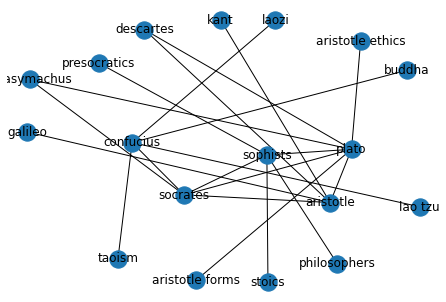

In [7]:
name='socrates'
language='en'

x=sugg_extractor(name,language)
graph_extractor(x,language)



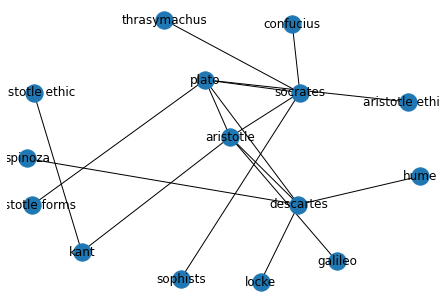

In [8]:
name='plato'
language='en'

x=sugg_extractor(name,language)
graph_extractor(x,language)

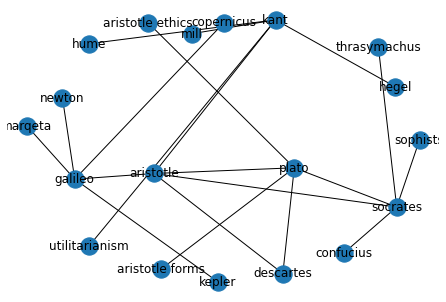

In [9]:
name='aristotle'
language='en'

x=sugg_extractor(name,language)
graph_extractor(x,language)

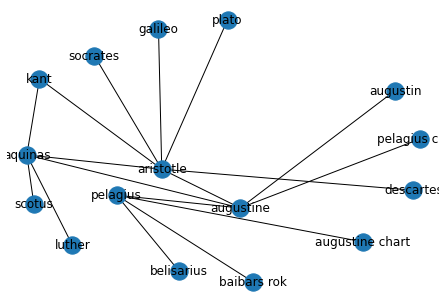

In [10]:
name='augustine'
language='en'

x=sugg_extractor(name,language)
graph_extractor(x,language)

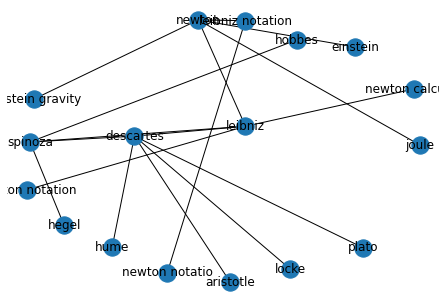

In [11]:
name='leibniz'
language='en'

x=sugg_extractor(name,language)
graph_extractor(x,language)

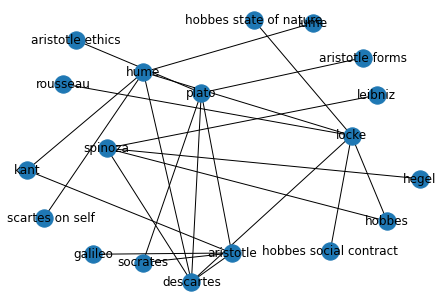

In [12]:
name='descartes'
language='en'

x=sugg_extractor(name,language)
graph_extractor(x,language)

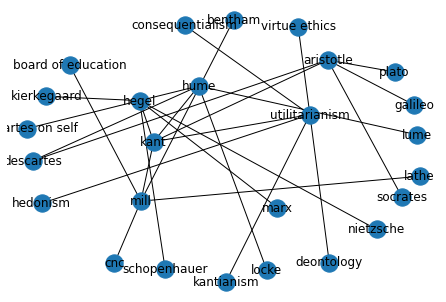

In [13]:
name='kant'
language='en'

x=sugg_extractor(name,language)
graph_extractor(x,'en')

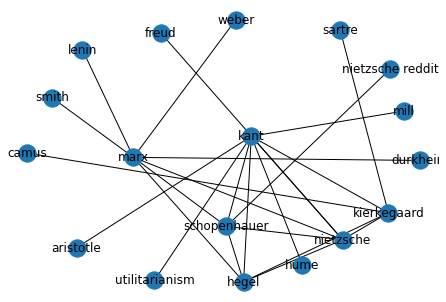

In [14]:
name='hegel'
language='en'

x=sugg_extractor(name,language)
graph_extractor(x,language)

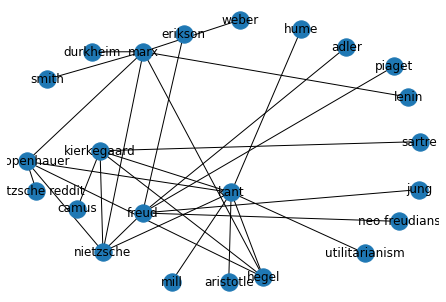

In [15]:
name='nietzsche'
language='en'

x=sugg_extractor(name,language)
graph_extractor(x,language)

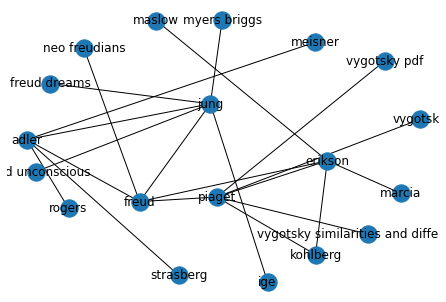

In [16]:
name='freud'
language='en'

x=sugg_extractor(name,language)
graph_extractor(x,language)

In [17]:
F=nx.Graph()
subset_key=[]
for i in graph_collector:    # Creo un grafico composto da tutti i grafici generati precedentemente
    F = nx.compose(F,i)
 
    
net=Network(notebook=True)
net.from_nx(F)
net.show('philosophers.html')


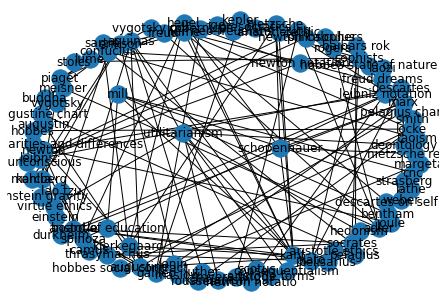

In [18]:
#Visualizzazione alternativa se pyvis non dovesse funzionare
pos=nx.spring_layout (F, k=4, scale=1, iterations=70)
nx.draw(F, pos,with_labels=True)

In [19]:
#Creo il dataframe con le informazioni del grafico ricavato unendo tutti i grafici
d3={"Reference":"Merged graph","Density":[nx.density(F)],"Clustering":[nx.average_clustering(F)],"Number of nodes":[F.number_of_nodes()],"Number of cliques":nx.graph_clique_number(F),"Number of bridges":[len(list(nx.bridges(F)))]}
df3=pd.DataFrame(data=d3)
frames2.append(df3)

In [20]:
#Unisco e visualizzo i dati riguardanti Densità, Clustering, bridges e nodi dei vari grafici
dataframe=pd.concat(frames2,ignore_index=True)
dataframe

,Reference,Density,Clustering,Number of cliques,Number of bridges,Number of nodes
0,Socrates,0.137255,0.155026,3,12,18
1,Plato,0.152381,0.040000,3,11,15
2,Aristotle,0.116959,0.078947,3,15,19
3,Augustine,0.141667,0.087202,3,12,16
4,Leibniz,0.125000,0.019608,3,14,17
5,Descartes,0.134503,0.092982,3,10,19
6,Kant,0.080000,0.000000,2,22,26
7,Hegel,0.156863,0.127116,4,12,18
8,Nietzsche,0.110672,0.071222,3,17,23
9,Freud,0.122807,0.089474,3,13,19


In [21]:
names=[]
connections=[]

for i in F:         # Creo un dataframe che mostra i nomi con più connessioni.
    names.append(i)
    connections.append(F.degree(i))
    
d = {'Names': names, 'Connections': connections}
df = pd.DataFrame(data=d)
df_sorted=df.sort_values('Connections',ascending=False, ignore_index=True)
df_sorted.to_csv('/Users/gabrieledettori/Desktop/most_influential_philosophers.csv')
df_sorted[:50]

,Names,Connections
0,kant,10
1,aristotle,7
2,marx,7
3,plato,7
4,piaget,6
5,locke,6
6,freud,6
7,utilitarianism,6
8,nietzsche,6
9,jung,6


<AxesSubplot:ylabel='Frequency'>

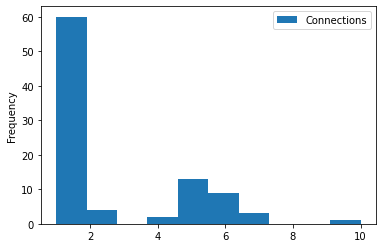

In [22]:
#Creo un grafico che mostra la frequenza delle connessioni in base al numero di filosofi che hanno quel determinato range di connessioni.
df_sorted.plot.hist(x='Names', y='Connections')

Kant, Aristotele, Cartesio, Nietzsche ed Hegel sono i 5 filosofi più influenti fra quelli generati dal nostro programma per quanto riguarda il numero di connessioni. 